# SMC on full model (not a two-timestep) in GenJAX 0.5.0
This notebook takes inspiration from the [Gen.dev tutorial on 'particle filtering'](https://www.gen.dev/tutorials/particle-filtering/tutorial) and attempts to show an implementation of basic SMC with resampling from the internal proposal distribution. The key here is the use of a masked scan combinator to represent masked sequential probabilistic computations using GenJAX

Below, we start with the masked scan combinator, which is a super tiny modified version of [George's original implementation](https://github.com/probcomp/genjax/issues/1184#issue-2381036171) using Dimap. There were originally some workarounds for bugs in v0.4.0 which have now been fixed in v0.5.0 (Shoutout to Sam Ritchie!). There are still a one workaround to a bug in this implementation ([GEN-295](https://linear.app/chi-fro/issue/GEN-295/genjax-unable-to-return-values-known-before-runtime-during)) in the `jax.lax.select(True, True, True)` line below, but the code below should work fine without the fear of your GPU exploding or having to deal with life-changing beartype errors from GenJAX. This also requires the version of mask combinator from my PR [here](https://github.com/probcomp/genjax/pull/1204) -- yet to be approved. This notebook was specifically tied to [this commit](https://github.com/probcomp/genjax/pull/1204/commits/9ddfef990db1c9c36df6ec52a13b1229dcc6ccca).

In [1]:
import jax
import time
import jax.numpy as jnp
import numpy as np
import genjax
from genjax import gen, Mask, Diff
from genjax import ChoiceMapBuilder as C
from genjax import UpdateProblemBuilder as U
from genjax import SelectionBuilder as S
import jax.tree_util as jtu
genjax.pretty()
import copy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import HTML as HTML_Display
from matplotlib.animation import FuncAnimation

# Credit to Rif for the simplified (and much better) masked_scan_combinator below 


def mstep_dimap_pre(state, flag):
   return flag, state, None

def mstep_dimap_post(args, masked_retval):
   return masked_retval.value

def masked_scan_combinator(step, **scan_kwargs):
   
   mstep = step.mask().dimap(
      pre=mstep_dimap_pre,
      post=mstep_dimap_post
   )
 
   return mstep.scan(**scan_kwargs)

# Model

Here we define a model that is identical to the example in the Gen.dev tutorial (model structure and noise parameters!). The idea is to sample velocities over time with some bearing measurement noise. In the masked scan combinator, we give as inputs the scan input and a Mask that stores a boolean array and xs (both of the same length). 

Just like how I often ignore my pile of unfolded clean laundry, a masked scan combinator with a boolean mask of false (for a specific timestep in this case) ignores its respective logpdf computations in weights and scores. In both cases, there is functionality to change this reality via correctly designed update moves (to be show later in the notebook, for the masked scan combinator specifically).

In [2]:
bearing = lambda x, y : jnp.atan2(y,x)
measurement_noise = 0.005
velocity_std = 1e-3

@gen
def model(T_arr):
    max_T = T_arr.shape[0]
    T = jnp.sum(T_arr)
    x0 = genjax.normal(0.01,0.01) @ 'x0'
    y0 = genjax.normal(0.95,0.01) @ 'y0'
    vx0 = genjax.normal(0.002,0.01) @ 'vx0'
    vy0 = genjax.normal(-0.013,0.01) @ 'vy0'
    z0 = genjax.normal(bearing(x0,y0), measurement_noise) @ 'z0'
    _, masked_retval = masked_scan_combinator(step, n = max_T)((x0,y0,vx0,vy0), jnp.arange(max_T) < T) @ 'step'
    return masked_retval

@gen
def step(carry, _):
    x, y, vx, vy = carry
    new_vx = genjax.normal(vx, velocity_std) @ 'vx'
    new_vy = genjax.normal(vy, velocity_std) @ 'vy'
    new_x = x + new_vx
    new_y = y + new_vy 
    z = genjax.normal(bearing(new_x, new_y), measurement_noise) @ 'z'
    return (new_x, new_y, new_vx, new_vy), (new_x, new_y, z)

model_importance = jax.jit(model.importance)

# Visualization

Here are a bunch of viz utils for this notebook. Nothing interesting to see here, you can move on, save your time. Probably should have put this in a separate file.

In [3]:
def visualize_trace(tr):
	
	x0 = tr.get_sample()['x0']
	y0 = tr.get_sample()['y0']
	z0 = tr.get_sample()['z0']
	retval = tr.get_retval()
	flag = tr.get_args()[0]
	xs, ys, zs = retval
	xs = xs[flag]
	ys = ys[flag]
	zs = zs[flag]
	all_xs = jnp.concat([jnp.array([x0]), xs])
	all_ys = jnp.concat([jnp.array([y0]), ys])
	all_zs = jnp.concat([jnp.array([z0]), zs])
	
	fig, ax = plt.subplots(1, 1, figsize=(5, 5))

	ax.set_xlim([min(0,all_xs.min()-0.02), all_xs.max()+0.02])
	ax.set_ylim([min(0, all_ys.min()-0.02), all_ys.max()+0.02])
	# ax.set_aspect('equal', 'box')

	obs_scatter = ax.scatter(all_xs, all_ys, 
			s=32,
			c='black', 
			marker='x',      
			alpha=1,   
			zorder=4)       

	start_point = ax.scatter(all_xs[0], all_ys[0],
			s=32,
			c='red',    
			marker='*',        
			alpha=1,            
			zorder=4                         
	)

	origin = ax.scatter(0, 0,
			s=32,
			c='black',    
			marker='o',        
			alpha=1,            
			zorder=4                         
	)

	for z in all_zs:
		if z > 0:
			height = 0.5
		else:
			height = -0.5
		z_line = Line2D([0,height/jnp.tan(z)], [0,height], color='orange')
		ax.add_line(z_line)

	path_line = Line2D(all_xs, all_ys, color = 'black', linewidth=0.4)
	ax.add_line(path_line)

	return plt.show()

def get_all_zs(tr, return_invalid = False):
	z0 = tr.get_sample()['z0']
	retval = tr.get_retval()
	flag = tr.get_args()
	*_, zs = retval
	if not return_invalid:
		zs = zs[flag]
	all_zs = jnp.concat([jnp.array([z0]), zs])
	return all_zs

def visualize_bearings(tr):
	plt.plot(get_all_zs(tr), marker = 'o')
	return plt.show()

def visualize_multiple_bearings(trs):
	# Assume every trace has the same valid length as the first one
	flag = trs.get_args()[0][0]
	num_traces = trs.get_args()[0].shape[0]
	def get_all_zs(tr):
		z0 = tr.get_sample()['z0']
		retval = tr.get_retval()
		*_, zs = retval
		zs = zs[flag]
		all_zs = jnp.concat([jnp.array([z0]), zs])
		return all_zs
	def generate_random_colors(N):
		np.random.seed(0)
		colors = np.random.rand(N, 3)
		return colors
	random_colors = generate_random_colors(num_traces)

	all_stacked_zs = jax.vmap(get_all_zs)(trs)
	for t_id in range(num_traces):
		plt.plot(all_stacked_zs[t_id], marker = 'o', color = random_colors[t_id])
	return plt.show()

def visualize_multiple_traces(trs, show_bearings = False):
	# Assume every trace has the same valid length as the first one
	flag = trs.get_args()[0][0]
	num_traces = trs.get_args()[0].shape[0]
	@jax.vmap
	def get_all_xs_and_ys(tr):
		x0 = tr.get_sample()['x0']
		y0 = tr.get_sample()['y0']
		z0 = tr.get_sample()['z0']
		retval = tr.get_retval()
		xs, ys, zs = retval
		xs = xs[flag]
		ys = ys[flag]
		zs = zs[flag]
		all_xs = jnp.concat([jnp.array([x0]), xs])
		all_ys = jnp.concat([jnp.array([y0]), ys])
		all_zs = jnp.concat([jnp.array([z0]), zs])
		return all_xs, all_ys, all_zs

	stacked_all_xs, stacked_all_ys, stacked_all_zs = get_all_xs_and_ys(trs)
	
	fig, ax = plt.subplots(1, 1, figsize=(5, 5))

	if show_bearings:
		min_x, min_y = 0,0
	else:
		min_x, min_y = np.inf,np.inf

	ax.set_xlim([min(min_x,stacked_all_xs.min()-0.02), stacked_all_xs.max()+0.02])
	ax.set_ylim([min(min_y, stacked_all_ys.min()-0.02), stacked_all_ys.max()+0.02])
	# ax.set_aspect('equal', 'box')
	def generate_random_colors(N):
		np.random.seed(0)
		colors = np.random.rand(N, 3)
		return colors
	
	random_colors = generate_random_colors(num_traces)

	for t_id in range(num_traces):

		obs_scatter = ax.scatter(stacked_all_xs[t_id], stacked_all_ys[t_id], 
				s=32,
				c=random_colors[t_id], 
				marker='x',      
				alpha=1,   
				zorder=4)       
		path_line = Line2D(stacked_all_xs[t_id], stacked_all_ys[t_id], color = random_colors[t_id], linewidth=0.4)
		ax.add_line(path_line)

		start_point = ax.scatter(stacked_all_xs[t_id][0], stacked_all_ys[t_id][0],
				s=32,
				c='red',    
				marker='*',        
				alpha=1,            
				zorder=4                         
		)

		if show_bearings:
			for z in stacked_all_zs[t_id]:
				if z > 0:
					height = 0.5
				else:
					height = -0.5
				z_line = Line2D([0,height/jnp.tan(z)], [0,height], color=random_colors[t_id])
				ax.add_line(z_line)

	origin = ax.scatter(0, 0,
			s=32,
			c='black',    
			marker='o',        
			alpha=1,            
			zorder=4                         
	)

	return plt.show()

def visualize_PF(PF, gt_trace, show_bearings = True):
	# Assume we have the GT trace
	trs = PF.particles
	flag = trs.get_args()[0][0]
	num_traces = trs.get_args()[0].shape[0]
	
	def get_all_xs_and_ys(tr):
		x0 = tr.get_sample()['x0']
		y0 = tr.get_sample()['y0']
		z0 = tr.get_sample()['z0']
		retval = tr.get_retval()
		xs, ys, zs = retval
		xs = xs[flag]
		ys = ys[flag]
		zs = zs[flag]
		all_xs = jnp.concat([jnp.array([x0]), xs])
		all_ys = jnp.concat([jnp.array([y0]), ys])
		all_zs = jnp.concat([jnp.array([z0]), zs])
		return all_xs, all_ys, all_zs

	stacked_all_xs, stacked_all_ys, stacked_all_zs = jax.vmap(get_all_xs_and_ys)(trs)

	gt_xs, gt_ys, obs_zs = get_all_xs_and_ys(gt_trace)
	
	fig, ax = plt.subplots(1, 1, figsize=(5, 5))

	if show_bearings:
		min_x, min_y = 0,0
	else:
		min_x, min_y = np.inf,np.inf

	ax.set_xlim([min(min_x,stacked_all_xs.min()-0.02), stacked_all_xs.max()+0.02])
	ax.set_ylim([min(min_y, stacked_all_ys.min()-0.02), stacked_all_ys.max()+0.02])
	# ax.set_ylim([0.2, 1.])
	# ax.set_xlim([-0.3, 0.4])
	# ax.set_aspect('equal', 'box')
	def generate_random_colors(N):
		np.random.seed(0)
		colors = np.random.rand(N, 3)
		return colors
	
	random_colors = generate_random_colors(num_traces)

	for t_id in range(num_traces):

		inferred_scatter = ax.scatter(stacked_all_xs[t_id], stacked_all_ys[t_id], 
				s=32,
				c=random_colors[t_id], 
				marker='x',      
				alpha=1,   
				zorder=4)       
		path_line = Line2D(stacked_all_xs[t_id], stacked_all_ys[t_id], color = random_colors[t_id], linewidth=0.4)
		ax.add_line(path_line)

		start_point = ax.scatter(stacked_all_xs[t_id][0], stacked_all_ys[t_id][0],
				s=32,
				c='red',    
				marker='*',        
				alpha=1,            
				zorder=4                         
		)

	if show_bearings:
		for z in obs_zs:
			if z > 0:
				height = 0.5
			else:
				height = -0.5
			z_line = Line2D([0,height/jnp.tan(z)], [0,height], color='orange')
			ax.add_line(z_line)

	obs_scatter = ax.scatter(gt_xs, gt_ys, 
			s=20,
			c='red', 
			marker='o',      
			alpha=1,   
			zorder=4)       
	path_line = Line2D(gt_xs, gt_ys, color = 'red', linewidth=1)
	ax.add_line(path_line)

	origin = ax.scatter(0, 0,
			s=32,
			c='black',    
			marker='o',        
			alpha=1,            
			zorder=4                         
	)

	return plt.show()

def animate_PF(particle_list, gt_trace = None, show_full_posterior = False, show_bearings = True, fps = 10, lims = None):
	# Assume we have the GT trace
	num_steps = len(particle_list)
	num_traces = particle_list[0].get_args()[0].shape[0]
	
	def get_all_xs_and_ys(tr, flag):
		x0 = tr.get_sample()['x0']
		y0 = tr.get_sample()['y0']
		z0 = tr.get_sample()['z0']
		retval = tr.get_retval()
		xs, ys, zs = retval
		if not show_full_posterior:
			xs = xs[flag]
			ys = ys[flag]
			zs = zs[flag]
		all_xs = jnp.concat([jnp.array([x0]), xs])
		all_ys = jnp.concat([jnp.array([y0]), ys])
		all_zs = jnp.concat([jnp.array([z0]), zs])
		return all_xs, all_ys, all_zs
	
	xs_over_time, ys_over_time, zs_over_time = [],[],[]
	for t in range(num_steps):
		# print(f"{t+1}/{num_steps}")
		trs = particle_list[t]
		flag = trs.get_args()[0][0]
		stacked_all_xs, stacked_all_ys, stacked_all_zs = jax.vmap(get_all_xs_and_ys, in_axes = (0, None))(trs, flag)
		xs_over_time.append(stacked_all_xs)
		ys_over_time.append(stacked_all_ys)
		zs_over_time.append(stacked_all_zs)

	init_flag = particle_list[-1].get_args()[0][0]
	gt_xs, gt_ys, obs_zs = get_all_xs_and_ys(gt_trace, init_flag)
	
	fig, ax = plt.subplots(1, 1, figsize=(5, 5))

	if lims is None:
		if show_bearings:
			min_x, min_y = 0,0
		else:
			min_x, min_y = np.inf,np.inf

		min_over_time_x = min([x.min() for x in xs_over_time])
		min_over_time_y = min([y.min() for y in ys_over_time])
		max_over_time_x = max([x.max() for x in xs_over_time])
		max_over_time_y = max([y.max() for y in ys_over_time])

		ax.set_xlim([min(min_x,min_over_time_x-0.02), max_over_time_x+0.02])
		ax.set_ylim([min(min_y, min_over_time_y-0.02), max_over_time_y+0.02])
	else:
		ax.set_xlim([lims[0][0], lims[0][1]])
		ax.set_ylim([lims[1][0], lims[1][1]])

	def generate_random_colors(N):
		np.random.seed(0)
		colors = np.random.rand(N, 3)
		return colors
	
	random_colors = generate_random_colors(num_traces)
	
	if show_bearings:
		z = obs_zs[0]
		if z > 0:
			height = 0.5
		else:
			height = -0.5
		z_line = Line2D([0,height/jnp.tan(z)], [0,height], color='orange')
		ax.add_line(z_line)

		origin = ax.scatter(0, 0,
				s=32,
				c='black',    
				marker='o',        
				alpha=1,            
				zorder=4                         
		)

	particle_lines = ax.plot(xs_over_time[0].T, ys_over_time[0].T, 
			markersize=5,
			# c=random_colors, 
			marker='x',      
			alpha=1,   
			zorder=4)       

	obs_scatter = ax.plot(gt_xs[0], gt_ys[0], 
			markersize=5,
			c='red', 
			marker='o',      
			alpha=1,   
			zorder=4)      
	start_point = ax.scatter(gt_xs[0], gt_ys[0],
			s=32,
			c='black',    
			marker='*',        
			alpha=1,            
			zorder=4                         
	)
	
	print("Trace processing complete")
	def init_func():
		pass
			
	def update(frame):
		print(f"rendering frame {frame}")
		for t_id in range(num_traces):
			particle_lines[t_id].set_data(xs_over_time[frame][t_id], ys_over_time[frame][t_id])
		if show_bearings:
			z = obs_zs[frame]
			if z > 0:
				height = 0.5
			else:
				height = -0.5
			z_line = Line2D([0,height/jnp.tan(z)], [0,height], color='orange')
			ax.add_line(z_line)
		obs_scatter[0].set_data(gt_xs[:frame], gt_ys[:frame])

	animation = FuncAnimation(fig, update, frames=num_steps, init_func=init_func, interval=1000//fps)
	plt.close()
	return HTML_Display(animation.to_html5_video())

# A single run of the model

Assuming we know the initial conditions of the moving object in gt_chm (because who even does inference for initial conditions anyway?), we can generate a run of the model and visualize the path taken along with the bearing measurements. The important thing here is to note is how we specify the timesteps we want the sequential computations to be valid for (<= the max T) by looking at gt_model_args. This will be important a few cells later. We now take these measurements as *observations* from now on, and pretend that we got this data from somewhere else. The red point on the first viz shows the starting point. The second viz shows how the bearing (vertical axis) changes over the timesteps.

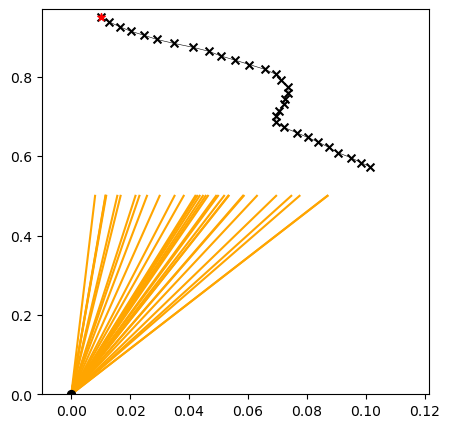

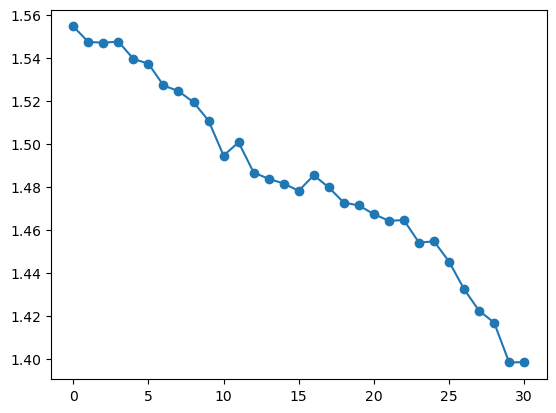

In [4]:
# USER SPECIFIED SECTION (Feel free to play around with this)
max_T = 30
run_till_T = 30
gt_chm = C.d({'x0' : 0.01, 'y0' : 0.95, 'vx0' : 0.002, 'vy0' : -0.013})

# Generate ground truth observations and visualize them
# NOTE: All gt_ prefixes are used to denote ground truth related variables
# For the sake of this example, the PRNG key of 1 looks good, but you could play around 
# with it the get to generate multiple random observations
gt_key = jax.random.PRNGKey(1)
gt_model_args = (jnp.arange(max_T) < run_till_T,)
gt_tr, _ = model_importance(gt_key, gt_chm, gt_model_args)
# gt_zs = get_all_zs(gt_tr)
visualize_trace(gt_tr)
visualize_bearings(gt_tr)

For pure entertainment, we could also mess with the choicemap using GenJAX's ChoiceMapBuilder to give us alternative paths that respect the constraints. The cell below aims to show how that can be easily done. In this case, changing the vertical velocity at specific timesteps (T = 1, T = 15).

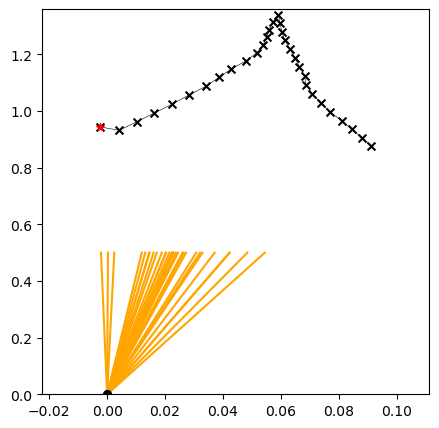

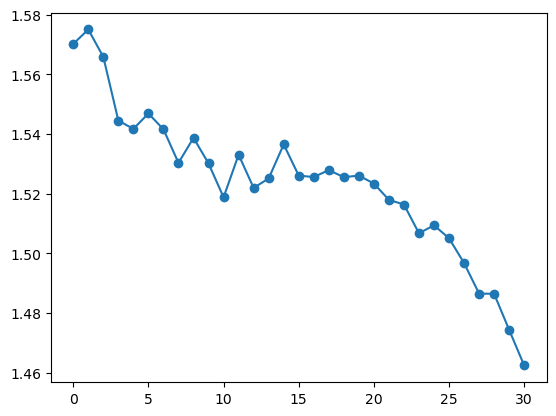

In [5]:
key = jax.random.PRNGKey(0)
chm = C['step', 1, 'vy'].set(0.03).at['step', 15, 'vy'].set(-0.03)
tr, _ = model_importance(key, chm, (jnp.arange(max_T) < 30,))
visualize_trace(tr)
visualize_bearings(tr)

No JAX notebook can be complete without showing that the computations can be parallelized. The cell below runs a batched importance and visualizes 3 trace runs with known initial conditions

/var/tmp/ipykernel_17775/2881494569.py:134: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  obs_scatter = ax.scatter(stacked_all_xs[t_id], stacked_all_ys[t_id],


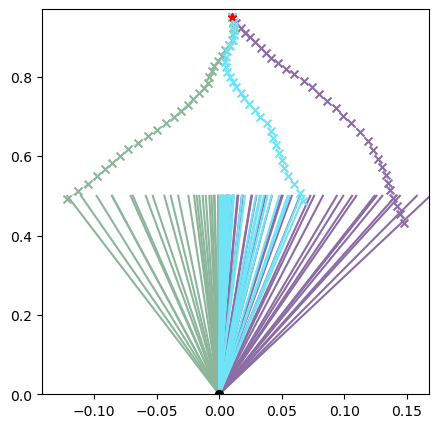

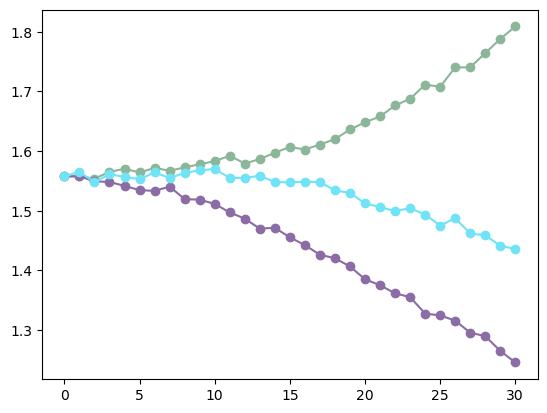

In [6]:
gt_keys = jax.random.split(gt_key, 3)
gt_trs, _ = jax.vmap(model_importance, in_axes = (0,None,None))(gt_keys, gt_chm, gt_model_args)
visualize_multiple_traces(gt_trs, show_bearings=True)
visualize_multiple_bearings(gt_trs)

The cell below contains code to run a particle filter, modeled directly after the Gen.dev implementation of particle filters. We also have to define a procedure to create an update problem. The way SMC works with the masked scan combinator here is that we update the 'tangent' field of the argdiff into the model (which specifies how many sequential 'valid/unmasked' computations). By giving the observation at that timestep + switching the argdiff to the new bool array, we can expect an SMCP3 update move with properly weighted particles (contingent on my [PR](https://github.com/probcomp/genjax/pull/1204) being correct)

In [7]:
# modeling after Gen's pf
from jax.scipy.special import logsumexp
from genjax import ExactDensity, Pytree

normalize_log_weights = lambda log_weights : log_weights - logsumexp(log_weights)
effective_sample_size = lambda log_weights : jnp.exp(-logsumexp(2. * normalize_log_weights(log_weights)))

def make_update_problem_for_step_t(max_T, t, z_obs, *args):
    # starting from t = 1 (first step of SMC). Note that the chm indexing into 'step'
    # would be t - 1 in this case
    argdiffs = (
        *Diff.tree_diff_no_change(args),
        Diff.unknown_change(jnp.arange(max_T) < t),
    )
    chm = C['step', t-1, 'z'].set(z_obs)
    return U.g(argdiffs, chm)

class genjax_pf:
    def __init__(self):
        self.particles = None
        self.weights = None
        self.num_particles = 0
        self.updater = None
    def initialize_particle_filter(self, key, model, model_args, observations, num_particles):
        keys = jax.random.split(key,num_particles)
        self.num_particles = num_particles
        self.updater_vmap = jax.jit(jax.vmap(
            lambda particle, key, update_problem: particle.update(key, update_problem), in_axes = (0,0,None)))
        self.idx_resampler = jax.jit(jax.vmap(genjax.categorical.simulate, in_axes=(0, None)))
        self.particle_resampler = jax.jit(jax.vmap(lambda idx, particles:jtu.tree_map(lambda v : v[idx], particles), in_axes = (0, None)))        
        self.particles, self.weights = jax.jit(jax.vmap(model.importance, in_axes = (0,None,None)))(keys, observations, model_args)
    def particle_filter_step(self, key, update_problem):
        keys = jax.random.split(key, self.num_particles)
        self.particles, incremental_weights, _, _ = self.updater_vmap(self.particles, keys, update_problem)
        self.weights = self.weights + incremental_weights
    def maybe_resample(self, key):
        idxs = self.idx_resampler(
            jax.random.split(key, self.num_particles), (self.weights,)
        ).get_retval()
        self.particles = self.particle_resampler(idxs, self.particles)
        self.weights = jnp.zeros(self.num_particles)


# class genjax_pf:
#     def __init__(self):
#         self.particles = None
#         self.weights = None
#         self.num_particles = 0
#         self.updater = None
#     def initialize_particle_filter(self, key, model, model_args, observations, num_particles):
#         keys = jax.random.split(key,num_particles)
#         self.num_particles = num_particles
#         self.updater_vmap = jax.vmap(
#             lambda particle, key, update_problem: particle.update(key, update_problem), in_axes = (0,0,None))
#         self.particles, self.weights = jax.vmap(model.importance, in_axes = (0,None,None))(keys, observations, model_args)
#     def particle_filter_step(self, key, update_problem):
#         keys = jax.random.split(key, self.num_particles)
#         self.particles, incremental_weights, _, _ = self.updater_vmap(self.particles, keys, update_problem)
#         self.weights = self.weights + incremental_weights
#     def maybe_resample(self, key):
#         idxs = jax.vmap(genjax.categorical.simulate, in_axes=(0, None))(
#             jax.random.split(key, self.num_particles), (self.weights,)
#         ).get_retval()
#         self.particles = jax.vmap(lambda idx:jtu.tree_map(lambda v : v[idx], self.particles))(idxs)
#         self.weights = jnp.zeros(self.num_particles)

Now the code below shows an example of SMC with resampling (triggered by the effective sample size). Notice that we start the args with run_till_T = 0 and then sequentially update the argdiffs and observations via the update problem. The 'all_zs' represent the observations. Note: This implementation is slow, might be an issue with jitting/recompilation --> I'm sure this version of SMC with the full model should be much faster.

In [12]:
# WARNING/NOTE: This implementation of SMC is still very slow, I will have to look into the specific
PF = genjax_pf()
key = jax.random.PRNGKey(9867324234324)
all_zs = get_all_zs(gt_tr)
inference_chm = C.d({
    'z0' : all_zs[0],
})
PARTICLE_LIST = []
run_till_T = 0
model_args = (jnp.arange(max_T) < run_till_T,)
PF.initialize_particle_filter(key, model, model_args, inference_chm, 500)
PARTICLE_LIST.append(copy.deepcopy(PF.particles))
update_prb = U.g((None, None), inference_chm)
start_time = time.time()
for t in range(1,max_T+1):
    print(t)
    update_prb = make_update_problem_for_step_t(max_T, t, all_zs[t])
    key, subkey = jax.random.split(key)
    PF.particle_filter_step(key, update_prb)
    ESS = effective_sample_size(PF.weights)
    print("ESS = ", ESS)
    if  ESS < 0.3 * PF.num_particles:
        print("resampling!")
        PF.maybe_resample(subkey)
    PARTICLE_LIST.append(copy.deepcopy(PF.particles))
    # print("time taken = ", time.time() - start_time)
    start_time = time.time()

1
ESS =  98.075745
resampling!
2
ESS =  244.12158
3
ESS =  89.80277
resampling!
4
ESS =  260.83252
5
ESS =  174.51
6
ESS =  105.68832
resampling!
7
ESS =  164.38144
8
ESS =  66.71151
resampling!
9
ESS =  355.878
10
ESS =  380.51804
11
ESS =  377.60455
12
ESS =  17.768522
resampling!
13
ESS =  468.08002
14
ESS =  465.86844
15
ESS =  458.62
16
ESS =  413.60617
17
ESS =  51.118862
resampling!
18
ESS =  448.59656
19
ESS =  446.99957
20
ESS =  446.99957
21
ESS =  446.99957
22
ESS =  447.00302
23
ESS =  447.00302
24
ESS =  447.00302
25
ESS =  447.00302
26
ESS =  446.99957
27
ESS =  447.00003
28
ESS =  447.00302
29
ESS =  52.999924
resampling!
30
ESS =  500.00006


Now we can visualize the sampled traces. The red line with 'o' shaped markers show the ground truth, while the others are the set of particles after inference. Rendering the viz is also incredibly slow. I am in talks with Matt Hubert who is very kindly helping me with genstudio implementations

In [13]:
animate_PF(PARTICLE_LIST, gt_tr, show_full_posterior=False, show_bearings=True)

Trace processing complete
rendering frame 0
rendering frame 1
rendering frame 2
rendering frame 3
rendering frame 4
rendering frame 5
rendering frame 6
rendering frame 7
rendering frame 8
rendering frame 9
rendering frame 10
rendering frame 11
rendering frame 12
rendering frame 13
rendering frame 14
rendering frame 15
rendering frame 16
rendering frame 17
rendering frame 18
rendering frame 19
rendering frame 20
rendering frame 21
rendering frame 22
rendering frame 23
rendering frame 24
rendering frame 25
rendering frame 26
rendering frame 27
rendering frame 28
rendering frame 29
rendering frame 30


In [14]:
animate_PF(PARTICLE_LIST, gt_tr, show_full_posterior=True, show_bearings=True)

Trace processing complete
rendering frame 0
rendering frame 1
rendering frame 2
rendering frame 3
rendering frame 4
rendering frame 5
rendering frame 6
rendering frame 7
rendering frame 8
rendering frame 9
rendering frame 10
rendering frame 11
rendering frame 12
rendering frame 13
rendering frame 14
rendering frame 15
rendering frame 16
rendering frame 17
rendering frame 18
rendering frame 19
rendering frame 20
rendering frame 21
rendering frame 22
rendering frame 23
rendering frame 24
rendering frame 25
rendering frame 26
rendering frame 27
rendering frame 28
rendering frame 29
rendering frame 30


/var/tmp/ipykernel_17775/2881494569.py:215: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  inferred_scatter = ax.scatter(stacked_all_xs[t_id], stacked_all_ys[t_id],


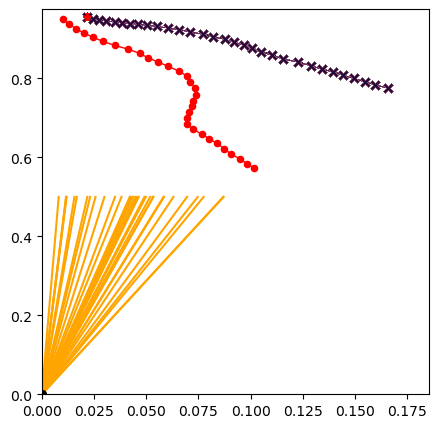

In [15]:
visualize_PF(PF, gt_tr, show_bearings=True) # viz of the final frame

TODO:
1. Animations of SMC (Done)
2. Custom Proposals (Done)
3. Rejuvenation examples

Ignore everything below

# Let's change the model
We see that the SMC run above gives us a reasonable set of trajectories after inference, but there was a little 'hack' in the demo. Notice that the initial position of the object is concentrated at (0.01, 0.95) -- hardcoded in the model. Since the ground truth data we generated was a simulation of the model, all our SMC particle initial guesses concentrated around the 'correct' initial position.

What if the model has to sample the initial position from a broad prior? The model below is now edited

In [ ]:
@gen
def new_model(T_arr):
    max_T = T_arr.shape[0]
    T = jnp.sum(T_arr)
    x_mean = genjax.uniform(-2.,2.) @ 'x_mean'
    y_mean = genjax.uniform(-2.,2.) @ 'y_mean'
    x0 = genjax.normal(x_mean,0.01) @ 'x0'
    y0 = genjax.normal(y_mean,0.01) @ 'y0'
    vx0 = genjax.normal(0.002,0.01) @ 'vx0'
    vy0 = genjax.normal(-0.013,0.01) @ 'vy0'
    z0 = genjax.normal(bearing(x0,y0), measurement_noise) @ 'z0'
    _, masked_retval = masked_scan_combinator(step, n = max_T)((x0,y0,vx0,vy0), jnp.arange(max_T) < T) @ 'step'
    return masked_retval

new_model_importance = jax.jit(new_model.importance)

In [ ]:
PF_no_cp = genjax_pf()
key = jax.random.PRNGKey(864764)
all_zs = get_all_zs(gt_tr)
inference_chm = C.d({
    'z0' : all_zs[0],
})
PARTICLE_LIST_no_cp = []
run_till_T = 0
model_args = (jnp.arange(max_T) < run_till_T,)
PF_no_cp.initialize_particle_filter(key, new_model, model_args, inference_chm, 500)
PARTICLE_LIST_no_cp.append(copy.deepcopy(PF_no_cp.particles))
update_prb = U.g(None, inference_chm)
for t in range(1,max_T+1):
    print(t)
    update_prb = make_update_problem_for_step_t(max_T, t, all_zs[t])
    key, subkey = jax.random.split(key)
    PF_no_cp.particle_filter_step(key, update_prb)
    ESS = effective_sample_size(PF_no_cp.weights)
    print("ESS = ", ESS)
    if  ESS < 0.3 * PF_no_cp.num_particles:
        print("resampling!")
        PF_no_cp.maybe_resample(subkey)
    PARTICLE_LIST_no_cp.append(copy.deepcopy(PF_no_cp.particles))

In [ ]:
animate_PF(PARTICLE_LIST_no_cp, gt_tr, show_full_posterior=False, show_bearings=True, lims = [[0,0.3],[0,1.4]])

In [ ]:

class genjax_pf:
    def __init__(self):
        self.particles = None
        self.weights = None
        self.num_particles = 0
        self.updater = None
    def initialize_particle_filter(self, key, model, model_args, observations, num_particles):
        keys = jax.random.split(key,num_particles)
        self.num_particles = num_particles
        self.updater_vmap = jax.jit(jax.vmap(
            lambda particle, key, update_problem: particle.update(key, update_problem), in_axes = (0,0,None)))
        self.idx_resampler = jax.jit(jax.vmap(genjax.categorical.simulate, in_axes=(0, None)))
        self.particle_resampler = jax.jit(jax.vmap(lambda idx, particles:jtu.tree_map(lambda v : v[idx], particles), in_axes = (0, None)))        
        self.particles, self.weights = jax.jit(jax.vmap(model.importance, in_axes = (0,None,None)))(keys, observations, model_args)
    def particle_filter_step(self, key, update_problem):
        keys = jax.random.split(key, self.num_particles)
        self.particles, incremental_weights, _, _ = self.updater_vmap(self.particles, keys, update_problem)
        self.weights = self.weights + incremental_weights
    def maybe_resample(self, key):
        idxs = self.idx_resampler(
            jax.random.split(key, self.num_particles), (self.weights,)
        ).get_retval()
        self.particles = self.particle_resampler(idxs, self.particles)
        self.weights = jnp.zeros(self.num_particles)

class genjax_pf_custom_proposal:
    def __init__(self):
        self.particles = None
        self.weights = None
        self.num_particles = 0
        self.updater = None
    def initialize_particle_filter(self, key, model, model_args, 
            observations, proposal, proposal_args, num_particles, choicemap_translator):
        key, subkey = jax.random.split(key,2)
        keys = jax.random.split(key, num_particles)
        subkeys = jax.random.split(subkey, num_particles)
        self.num_particles = num_particles
        self.idx_resampler = jax.jit(jax.vmap(genjax.categorical.simulate, in_axes=(0, None)))
        self.particle_resampler = jax.jit(jax.vmap(lambda idx, particles:jtu.tree_map(lambda v : v[idx], particles), in_axes = (0, None)))    
        self.updater_vmap = jax.jit(jax.vmap(
            lambda particle, key, update_problem: particle.update(key, update_problem), in_axes = (0,0,0)))
        proposed_choices, prop_weights, _ = jax.jit(jax.vmap(proposal.propose, in_axes = (0,None)))(subkeys, proposal_args)
        merged_choices = jax.vmap(lambda p,o : choicemap_translator(p)^o, in_axes = (0, None))(proposed_choices, observations)
        self.particles, self.weights = jax.jit(jax.vmap(model.importance, in_axes = (0,0,None)))(keys, merged_choices, model_args)
        self.weights -= prop_weights
    def set_step_proposal(self, step_proposal, choicemap_translator, update_problem_merger):
        self.step_proposer = jax.jit(jax.vmap(
            lambda k, particle, args : step_proposal.propose(k,(particle, *args)), 
            in_axes = (0,0,None)))
        self.step_merger = jax.jit(jax.vmap(lambda p,up : update_problem_merger(choicemap_translator(p), up), 
            in_axes = (0, None)))      
    def particle_filter_step(self, key, update_problem, proposal_args):
        keys = jax.random.split(key, self.num_particles)
        proposed_choices, prop_weights, _ = self.step_proposer(keys, self.particles, proposal_args)
        merged_update_problems = self.step_merger(proposed_choices, update_problem)
        self.particles, incremental_weights, _, _ = self.updater_vmap(self.particles, keys, merged_update_problems)
        self.weights = self.weights + incremental_weights - prop_weights
    def maybe_resample(self, key):
        idxs = self.idx_resampler(
            jax.random.split(key, self.num_particles), (self.weights,)
        ).get_retval()
        self.particles = self.particle_resampler(idxs, self.particles)
        self.weights = jnp.zeros(self.num_particles)

In [ ]:
from genjax import ExactDensity, Pytree
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

@Pytree.dataclass
class UniformCategorical(ExactDensity):
    def sample(self, key, labels, **kwargs):
        cat = tfd.Categorical(probs=jnp.ones(len(labels)) / len(labels))
        cat_index = cat.sample(seed=key)
        return labels[cat_index]

    def logpdf(self, v, labels, **kwargs):
        probs = jnp.ones(len(labels)) / len(labels)
        logpdf = jnp.log(probs)
        w = logpdf[0]
        return w
    
uniformcat = UniformCategorical()

@gen
def init_proposal_unmarginalized(init_z):
    # find the gradient and sample uniform points along the line with a length of 1
    discrete_xs = jnp.linspace(0,1,21) * jnp.cos(init_z)
    discrete_ys = jnp.linspace(0,1,21) * jnp.sin(init_z)

    x_discrete = uniformcat(discrete_xs) @ 'x_discrete'
    y_discrete = uniformcat(discrete_ys) @ 'y_discrete'

    x_mean = genjax.normal(x_discrete, 0.01) @ 'x_mean'
    y_mean = genjax.normal(y_discrete, 0.01) @ 'y_mean'
    return x_mean, y_mean

init_proposal = init_proposal_unmarginalized.marginal(
    selection=S["x_mean", "y_mean"]
)

def init_proposal_cm_translator(cm_in):
    x_mean = cm_in.v.c['x_mean']
    y_mean = cm_in.v.c['y_mean']
    return C.d({
        'x_mean': x_mean,
        'y_mean' : y_mean
    })

@gen
def empty_step_proposal(trace):
    _ = genjax.uniform(0.,1.) @ '_'
    return None

In [ ]:
key = jax.random.PRNGKey(435435)
all_zs = get_all_zs(gt_tr)
PARTICLE_LIST_cp = []
run_till_T = 0
model_args = (jnp.arange(max_T) < run_till_T,)
PF_cp = genjax_pf_custom_proposal()
PF_cp.initialize_particle_filter(
    key,
    new_model,
    model_args,
    C['z0'].set(all_zs[0]),
    init_proposal,
    (all_zs[0],),
    500,
    init_proposal_cm_translator
)
PARTICLE_LIST_cp.append(copy.deepcopy(PF_cp.particles))
PF_cp.set_step_proposal(empty_step_proposal, lambda x : x, lambda cm, up: up)
for t in range(1,max_T+1):
    print(t)
    key, subkey = jax.random.split(key)
    PF_cp.particle_filter_step(
        key,
        make_update_problem_for_step_t(max_T, t, all_zs[t]),
        (),
    )
    ESS = effective_sample_size(PF_cp.weights)
    print("ESS = ", ESS)
    if  ESS < 0.3 * PF_cp.num_particles:
        print("resampling!")
        PF_cp.maybe_resample(subkey)
    PARTICLE_LIST_cp.append(copy.deepcopy(PF_cp.particles))

In [ ]:
animate_PF(PARTICLE_LIST_cp, gt_tr, show_full_posterior=False, show_bearings=True, lims = [[0,0.3],[0,1.4]])

# Rejuvenation (WIP currently -- still broken)

In [ ]:
@gen
def rejuv_proposal(tr, *args):
    orig_x_mean = tr.get_sample()['x_mean']
    orig_y_mean = tr.get_sample()['y_mean']
    x_mean = genjax.normal(orig_x_mean, 0.25) @ 'x_mean'
    y_mean = genjax.normal(orig_y_mean, 0.25) @ 'y_mean'
    return x_mean, y_mean

def metropolis_hastings(mh_args, subkey):
    # jax.debug.print("{}", subkey)
    trace, proposal, proposal_args = mh_args
    model_args = trace.get_args()
    proposal_args_forward = (trace, *proposal_args)
    key, subkey = jax.random.split(subkey, 2)
    fwd_choices, fwd_weight, r = proposal.propose(subkey, proposal_args_forward)
    argdiffs = Diff.tree_diff_no_change(model_args)
    update = genjax.GenericProblem(argdiffs, fwd_choices)    
    key, subkey = jax.random.split(key, 2)
    new_trace, weight, _, discard = trace.update(subkey, update)
    proposal_args_backward = (new_trace, *proposal_args)
    bwd_weight, _ = proposal.assess(discard, proposal_args_backward)
    α = weight - fwd_weight + bwd_weight
    key, subkey = jax.random.split(key, 2)
    rtfn = jax.lax.cond(jnp.log(jax.random.uniform(subkey)) < α,
        lambda: (new_trace, True),
        lambda: (trace, False))    
    return (rtfn[0], proposal, proposal_args), rtfn
 
@jax.jit
def mh(trace, proposal, proposal_args, key):
    mh_keys = jax.random.split(key, num_updates)
    last_carry, mh_chain = jax.lax.scan(metropolis_hastings, (trace, proposal, proposal_args), mh_keys)
    return last_carry[0], mh_chain

In [ ]:
key = jax.random.PRNGKey(435435)
num_updates = 25
all_zs = get_all_zs(gt_tr)
PARTICLE_LIST_cp_rejuv = []
run_till_T = 0
model_args = (jnp.arange(max_T) < run_till_T,)
PF_cp_rejuv = genjax_pf_custom_proposal()
PF_cp_rejuv.initialize_particle_filter(
    key,
    new_model,
    model_args,
    C['z0'].set(all_zs[0]),
    init_proposal,
    (all_zs[0],),
    500,
    init_proposal_cm_translator
)
PARTICLE_LIST_cp_rejuv.append(copy.deepcopy(PF_cp_rejuv.particles))
accepts_arr = []
for t in range(1,max_T+1):
    print(t)
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, PF_cp_rejuv.num_particles)
    PF_cp_rejuv.particles, accepts = jax.vmap(mh, in_axes = (0,None,None,0))(PF_cp_rejuv.particles, rejuv_proposal, (), subkeys)
    accepts_arr.append(accepts[1])
    key, subkey = jax.random.split(key)
    PF_cp_rejuv.particle_filter_step(
        key,
        make_update_problem_for_step_t(max_T, t, all_zs[t]),
        empty_step_proposal,
        (),
        lambda x : x,
        lambda cm, up: up
    )
    ESS = effective_sample_size(PF_cp_rejuv.weights)
    print("ESS = ", ESS)
    if  ESS < 0.3 * PF_cp_rejuv.num_particles:
        print("resampling!")
        PF_cp_rejuv.maybe_resample(subkey)
    PARTICLE_LIST_cp_rejuv.append(copy.deepcopy(PF_cp_rejuv.particles))

In [ ]:
animate_PF(PARTICLE_LIST_cp_rejuv, gt_tr, show_full_posterior=False, show_bearings=True)

In [ ]:
accepts_arr[12][0]